# 1. Import library
Import all necessary libraries throughout the project.

In [1]:
import numpy as np
import pandas as pd
import os
import re
import seaborn as sns
from sklearn.base import clone, BaseEstimator, RegressorMixin
from sklearn.metrics import cohen_kappa_score, accuracy_score, mean_squared_error
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import missingno as msno

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error

### Helper function
These functions help us to read and preprocess parquet data.

In [2]:
def process_file(filename, dirname):
    """
    Reads a Parquet file, processes its contents,
    and returns n time series value extracted from the data and an id of a volunteer.

    Parameters:
        dirname (str): The directory path where the file is located.
        filename (str): The filename of the Parquet file to be read. The file is expected to be in a subdirectory
                        named after the `filename` parameter, containing a part file named 'part-0.parquet'.

    Returns:
        tuple: A tuple containing:
            - numpy.ndarray: Flattened time series data of the DataFrame (excluding the 'step' column).
            - str: A substring extracted from the `filename`, split by '=' - this is an ID of the volunteer
             and returning the second part.
    """
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    """
      Loads and preprocesses time series data from multiple files in a directory,
      returning a DataFrame containing n time series features for each volunteer.

      Parameters:
          dirname (str): The directory path containing the time series files to preprocess.

      Returns:
          pd.DataFrame: A DataFrame with the following structure:
              - Columns `stat_0`, `stat_1`, ..., `stat_n`: n time series features extracted from each file.
              - Column `id`: The unique identifiers (derived from filenames) for each volunteer.
    """
    ids = os.listdir(dirname)

    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))

    stats, indexes = zip(*results)

    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

# 2. Read data
This section is the data loading CSV and time series data, extract time series data part.

In [3]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')
dict = pd.read_csv('../input/child-mind-institute-problematic-internet-use/data_dictionary.csv')

train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

100%|██████████| 2/2 [00:00<00:00,  8.75it/s]


In [4]:
# Check if the timeseries data has labels
combine = pd.merge(train_ts, train[['id', 'sii']], on='id', how='left')
# Check the number of data points without labels
combine['sii'].isna().sum()
# => All data in the timeseries have labels

0

### Checking data's structure

In [5]:
# Hiểu data có gì
dict

,Instrument,Field,Description,Type,Values,Value Labels
0,Identifier,id,Participant's ID,str,NaN,NaN
1,Demographics,Basic_Demos-Enroll_Season,Season of enrollment,str,"Spring, Summer, Fall, Winter",NaN
2,Demographics,Basic_Demos-Age,Age of participant,float,NaN,NaN
3,Demographics,Basic_Demos-Sex,Sex of participant,categorical int,"0,1","0=Male, 1=Female"
4,Children's Global Assessment Scale,CGAS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
...,...,...,...,...,...,...
76,Sleep Disturbance Scale,SDS-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
77,Sleep Disturbance Scale,SDS-SDS_Total_Raw,Total Raw Score,int,NaN,NaN
78,Sleep Disturbance Scale,SDS-SDS_Total_T,Total T-Score,int,NaN,NaN
79,Internet Use,PreInt_EduHx-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN


In [6]:
# Xem thông tin train
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

In [7]:
# Xem thông tin test
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 59 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      20 non-null     object 
 1   Basic_Demos-Enroll_Season               20 non-null     object 
 2   Basic_Demos-Age                         20 non-null     int64  
 3   Basic_Demos-Sex                         20 non-null     int64  
 4   CGAS-Season                             10 non-null     object 
 5   CGAS-CGAS_Score                         8 non-null      float64
 6   Physical-Season                         14 non-null     object 
 7   Physical-BMI                            13 non-null     float64
 8   Physical-Height                         13 non-null     float64
 9   Physical-Weight                         13 non-null     float64
 10  Physical-Waist_Circumference            5 non-null      float64


# 3.Preprocess data
We perform preprocessing for both CSV data and time series data. Specifically, as follows:

## 3.1 Preprocess csv
We perform some techniques as mentioned in the presentation to preprocess CSV data, such as:
* We remove columns that exist in the training data but not in the testing data.
* We use KNN to resolve Nan Label.
* We use KNN to resolve with more than 70% missing data (Nan value).
* We remove columns ('season' features) with string values.
* In addition, we generate new important features.

In [10]:
# Kiểm tra các cột dư thừa ở trong train không có trong test
different_columns = set(train) - set(test)
different_columns # Cột sii là label, cần dữ lại

{'PCIAT-PCIAT_01',
 'PCIAT-PCIAT_02',
 'PCIAT-PCIAT_03',
 'PCIAT-PCIAT_04',
 'PCIAT-PCIAT_05',
 'PCIAT-PCIAT_06',
 'PCIAT-PCIAT_07',
 'PCIAT-PCIAT_08',
 'PCIAT-PCIAT_09',
 'PCIAT-PCIAT_10',
 'PCIAT-PCIAT_11',
 'PCIAT-PCIAT_12',
 'PCIAT-PCIAT_13',
 'PCIAT-PCIAT_14',
 'PCIAT-PCIAT_15',
 'PCIAT-PCIAT_16',
 'PCIAT-PCIAT_17',
 'PCIAT-PCIAT_18',
 'PCIAT-PCIAT_19',
 'PCIAT-PCIAT_20',
 'PCIAT-PCIAT_Total',
 'PCIAT-Season',
 'sii'}

In [11]:
# Lấy các cột chung giữa train và test
common_columns = train.columns.intersection(test.columns)

# Tạo lại data chỉ có các cột của test
train_df = train[common_columns]

# Gắn lại label
train_df['sii'] = train['sii']
train = train_df
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 60 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

## Heatmap

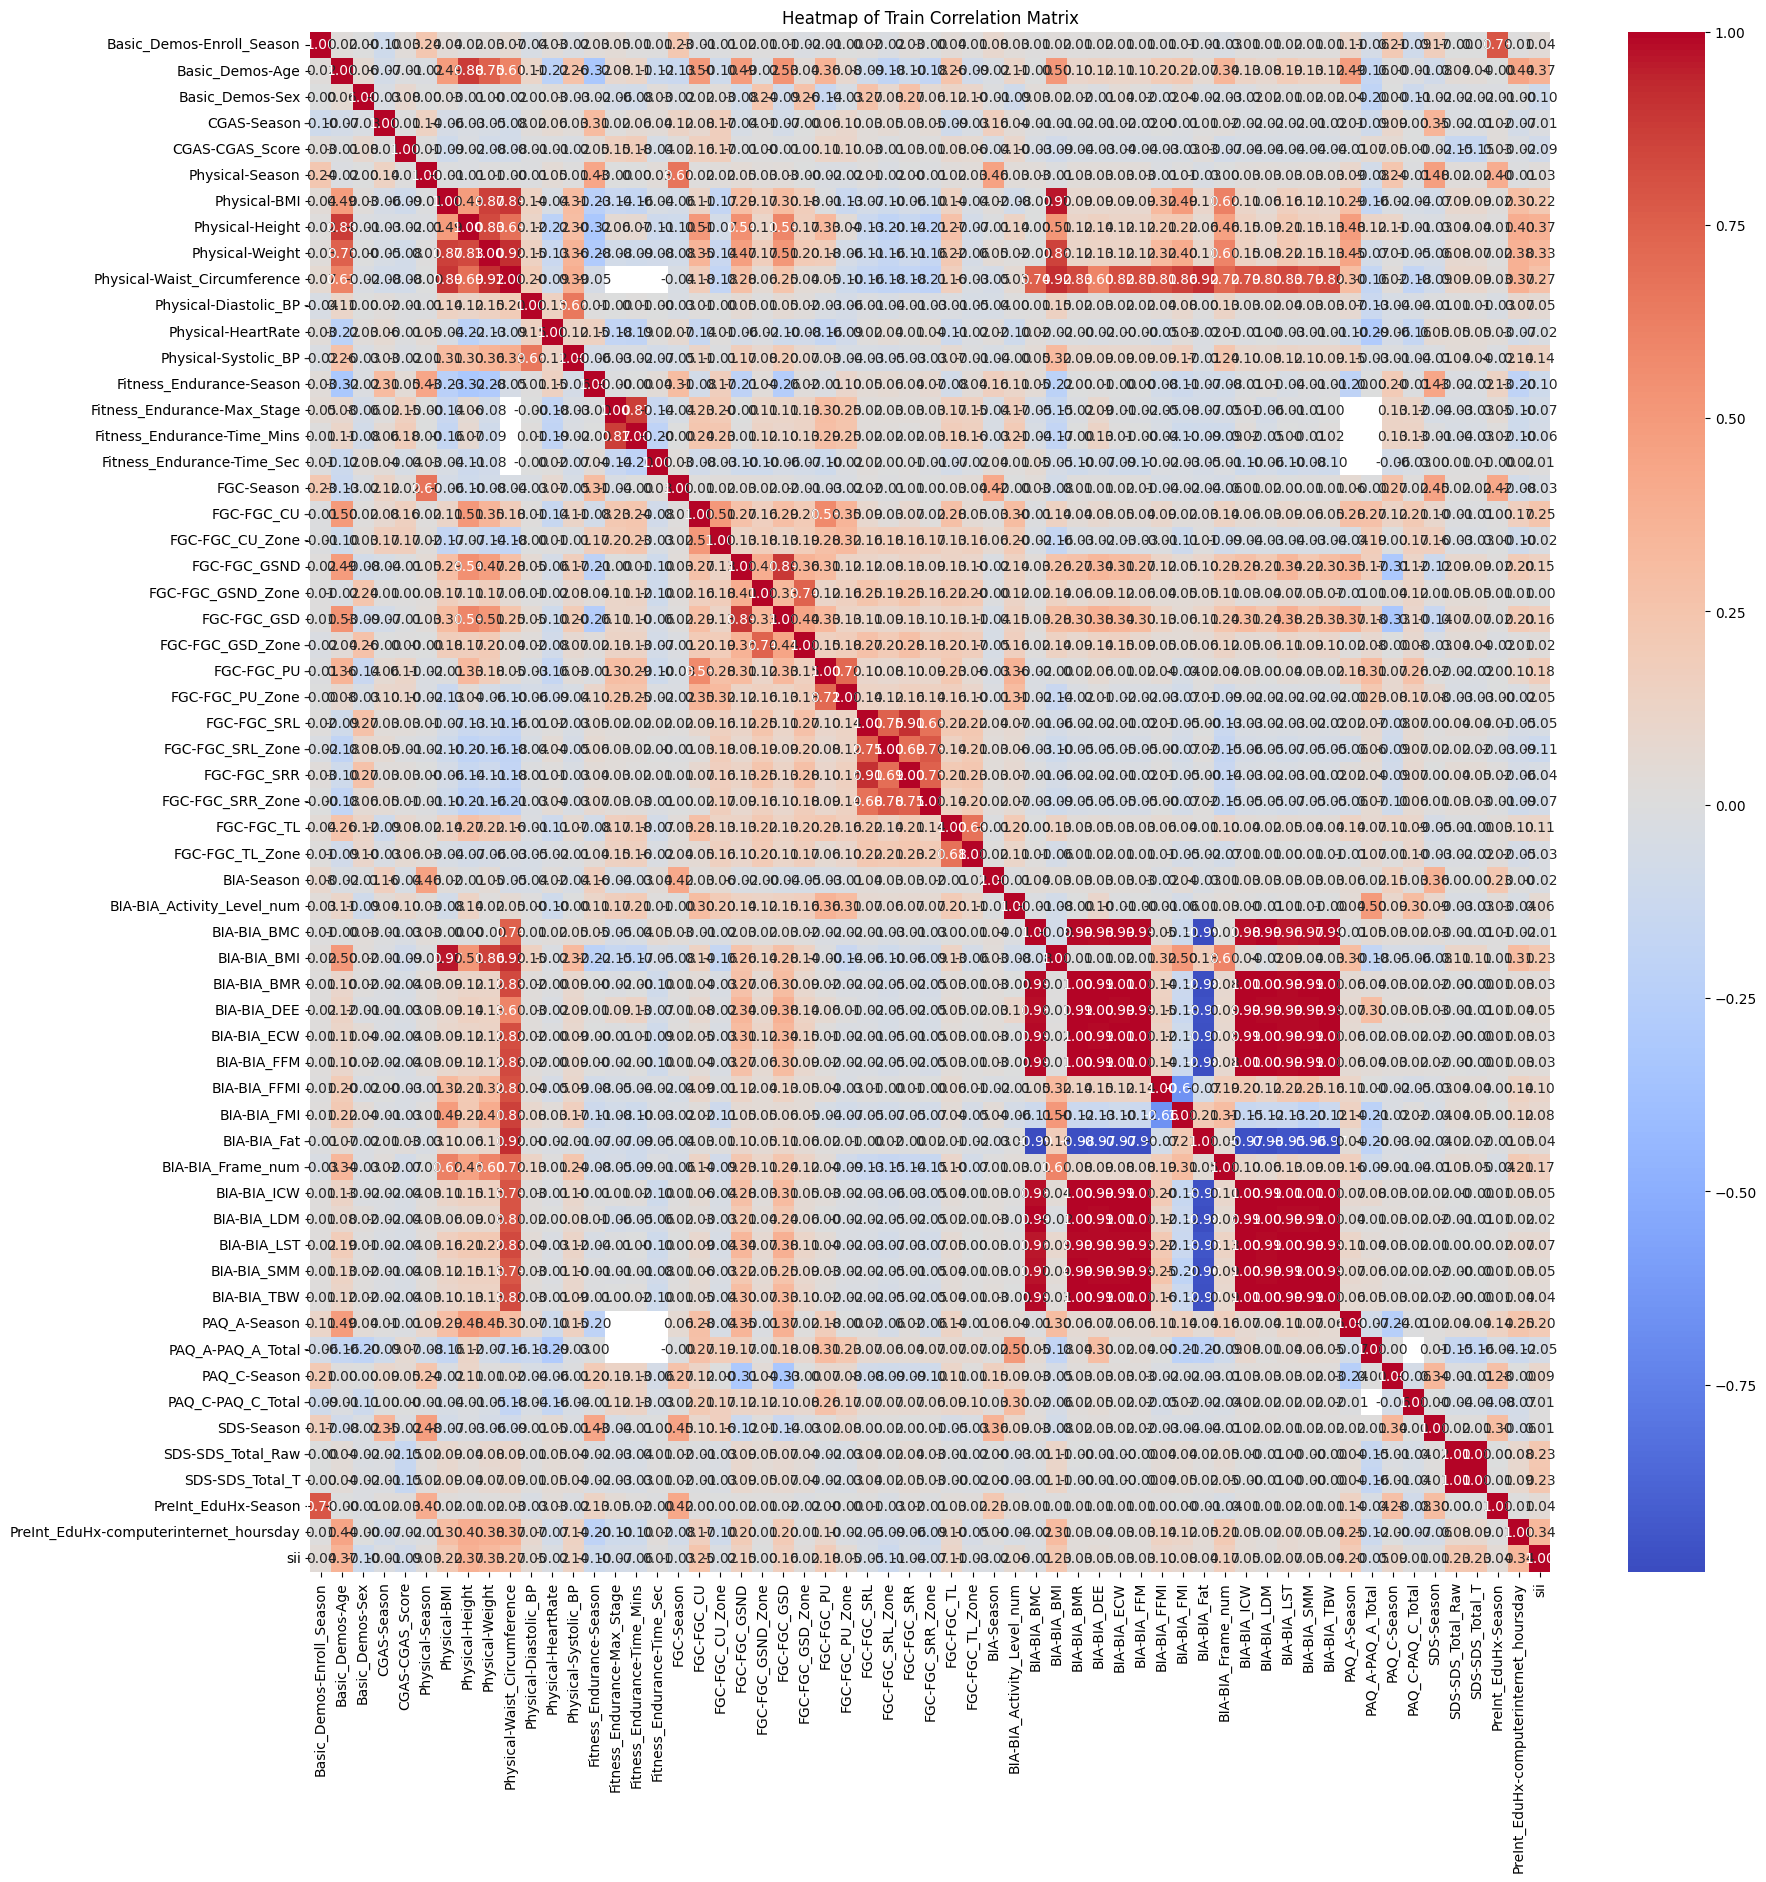

In [15]:
corr_train_matrix = train_no_id.corr()

# Vẽ heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(corr_train_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap of Train Correlation Matrix")
plt.show()

In [16]:
# Đặt ngưỡng tương quan (thường là 0.8 hoặc -0.8)
threshold = 0.8

# Lấy các cột có tương quan mạnh
# Chỉ lấy các phần tử trên đường chéo (các cột có tương quan với chính nó = 1)
upper_tri = corr_train_matrix.where(np.triu(np.ones(corr_train_matrix.shape), k=1).astype(bool))

# Tìm các cột có tương quan mạnh với nhau
columns_high_cor= [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]
columns_high_cor

['Physical-Height',
 'Physical-Weight',
 'Physical-Waist_Circumference',
 'Fitness_Endurance-Time_Mins',
 'FGC-FGC_GSD',
 'FGC-FGC_SRR',
 'BIA-BIA_BMI',
 'BIA-BIA_BMR',
 'BIA-BIA_DEE',
 'BIA-BIA_ECW',
 'BIA-BIA_FFM',
 'BIA-BIA_FFMI',
 'BIA-BIA_FMI',
 'BIA-BIA_Fat',
 'BIA-BIA_ICW',
 'BIA-BIA_LDM',
 'BIA-BIA_LST',
 'BIA-BIA_SMM',
 'BIA-BIA_TBW',
 'SDS-SDS_Total_T']

In [17]:
# Chọn ra các group có tính tương quan mạnh
group1 = ['Physical-Height',
 'Physical-Weight',
 'Physical-Waist_Circumference']
group2 = ['Fitness_Endurance-Time_Mins',
 'FGC-FGC_GSD',
 'FGC-FGC_SRR']
group3 = ['BIA-BIA_BMI',
 'BIA-BIA_BMR',
 'BIA-BIA_DEE',
 'BIA-BIA_ECW',
 'BIA-BIA_FFM',
 'BIA-BIA_FFMI',
 'BIA-BIA_FMI',
 'BIA-BIA_Fat',
 'BIA-BIA_ICW',
 'BIA-BIA_LDM',
 'BIA-BIA_LST',
 'BIA-BIA_SMM',
 'BIA-BIA_TBW',
 'SDS-SDS_Total_T']
group4 = ['Basic_Demos-Age', 'sii', 'PreInt_EduHx-computerinternet_hoursday']
# Gen Heatmap
group1_cor = train_no_id[group1].corr()
group2_cor = train_no_id[group2].corr()
group3_cor = train_no_id[group3].corr()
group4_cor = train_no_id[group4].corr()

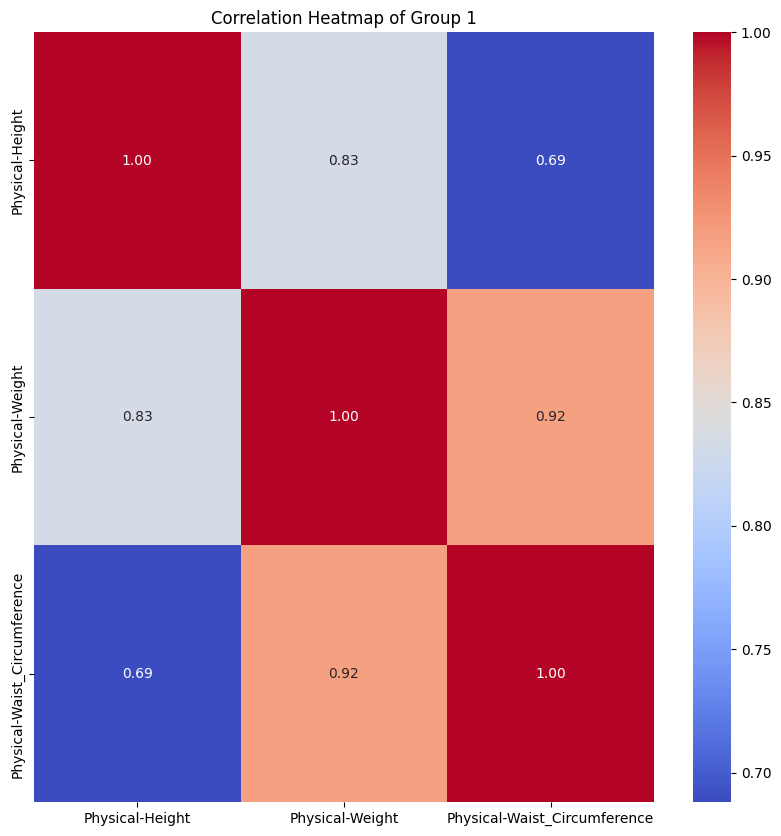

In [18]:
# Vẽ heatmap 1 Các chỉ số vật lý
plt.figure(figsize=(10, 10))
sns.heatmap(group1_cor, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title("Correlation Heatmap of Group 1")
plt.show()

Chỉ số vòng eo có sự liên quan với height và weight, 3 chỉ số này liên hệ với nhau.

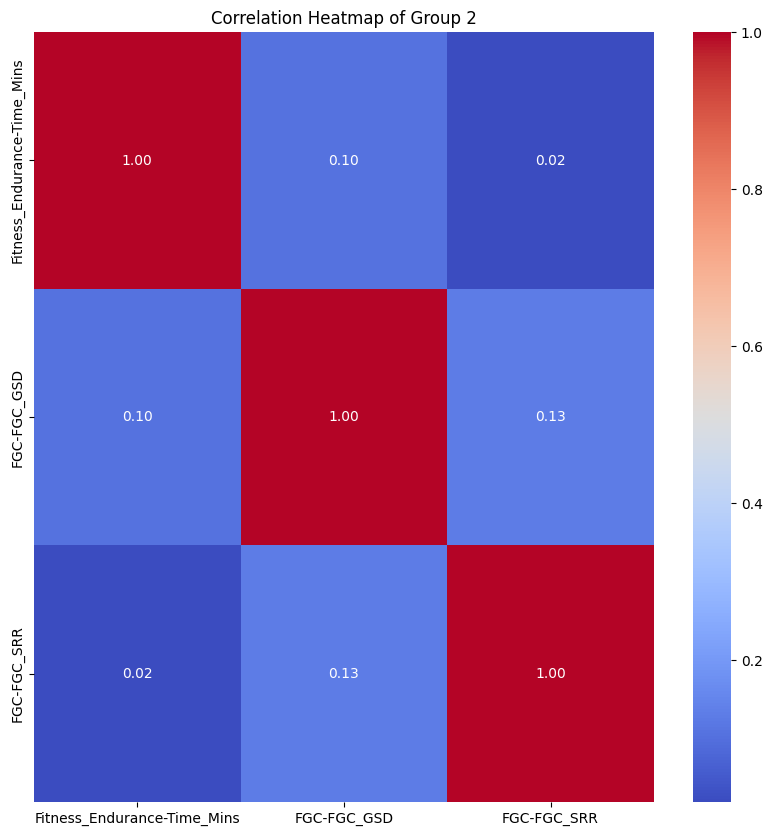

In [19]:
# Vẽ heatmap 2 Các chỉ số FGC
plt.figure(figsize=(10, 10))
sns.heatmap(group2_cor, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title("Correlation Heatmap of Group 2")
plt.show()

Bảng chỉ số này không có sự liên quan

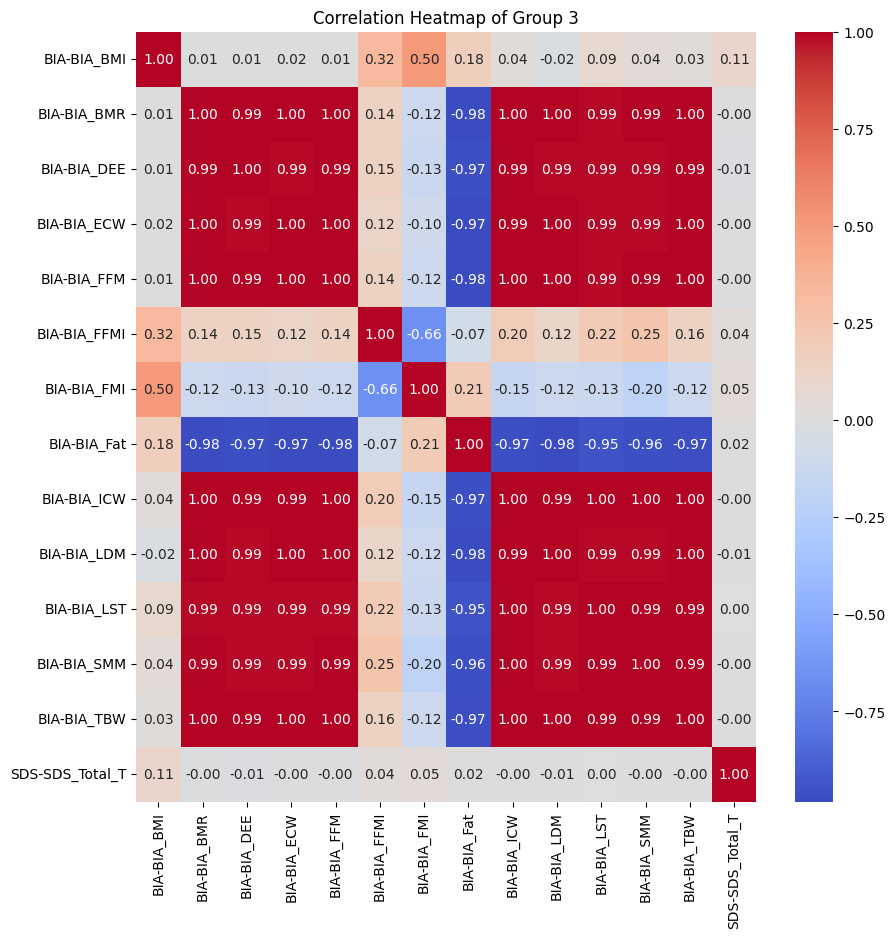

In [20]:
# Vẽ heatmap 3 Các chỉ số BMI
plt.figure(figsize=(10, 10))
sns.heatmap(group3_cor, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title("Correlation Heatmap of Group 3")
plt.show()

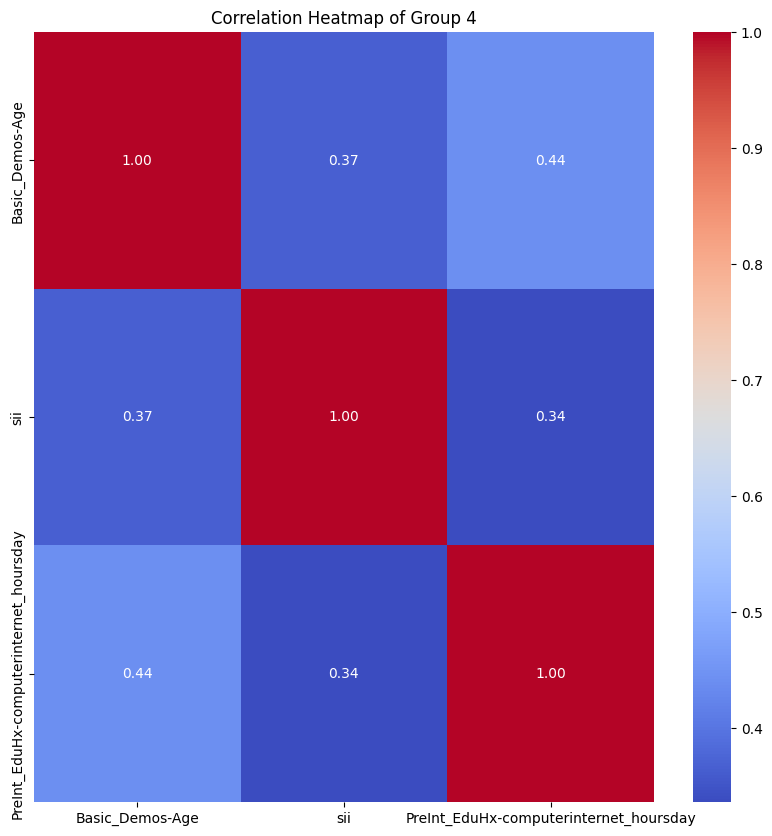

In [21]:
# Vẽ heatmap 4 Các chỉ số BMI
plt.figure(figsize=(10, 10))
sns.heatmap(group4_cor, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title("Correlation Heatmap of Group 4")
plt.show()

## Encode season (Optional)

In [23]:
def season_encode(df, kill_season=False):
    """
    Encodes seasonal data in a DataFrame or removes seasonal columns based on input parameters.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the data to process.
        kill_season (bool, optional):
            - If `True`, removes all columns with "Season" in their names.
            - If `False`, encodes string columns with season-related data using a predefined mapping.
            Default is `False`.

    Returns:
        pd.DataFrame:
            - If `kill_season=True`, a DataFrame with "Season" columns removed.
            - If `kill_season=False`, a DataFrame with seasonal data encoded and the `id` column preserved.

    Mapping:
        The seasonal strings are encoded as follows:
        - 'Spring' -> 1
        - 'Summer' -> 2
        - 'Fall'   -> 3
        - 'Winter' -> 4
        - NaN      -> 0
    """
    if kill_season:
        season_cols = [col for col in df.columns if 'Season' in col]
        df_ = df.drop(season_cols, axis=1)
        return df_

    df_no_id = df.drop(columns='id')
    string_columns = df_no_id.select_dtypes(include=['object']).columns.tolist()

    season_encode_map = {
        'Spring': 1,
        'Summer': 2,
        'Fall': 3,
        'Winter': 4,
        np.nan: 0
    }

    # Apply mapping for all string format columns
    df_no_id[string_columns] = df_no_id[string_columns].apply(lambda col: col.map(season_encode_map))
    df_no_id['id'] = df['id']
    return df_no_id

### Feature Engineering
Based on strong correlations between features in the data, thereby creating features that are more meaningful to prediction.

In [24]:
def feature_engineering(df_):
    """
    Performs feature engineering on a given DataFrame by creating new derived features
    related to physical health, body composition, and internet usage.

    Parameters:
        df_ (pd.DataFrame): The input DataFrame containing the necessary columns for feature calculations.

    Returns:
        pd.DataFrame: A new DataFrame with the original columns and additional engineered features.
    """

    df = df_.copy()
    # Product of BMI and Age
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    # Product of daily internet hours and Age
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    # Product of BMI and daily internet hours
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']

    # Ratio of body fat percentage to BMI
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    # Ratio of fat-free mass index to body fat percentage
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    # Ratio of fat mass index to body fat percentage
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    # Ratio of lean soft tissue to total body water
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    # Product of body fat percentage and basal metabolic rate
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    # Product of body fat percentage and daily energy expenditure
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    # Ratio of basal metabolic rate to weight
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    # Ratio of daily energy expenditure to weight
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    # Ratio of skeletal muscle mass to height
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    # Ratio of skeletal muscle mass to fat mass index
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    # Ratio of total body water to weight
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    # Ratio of intracellular water
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    # Product of BMI and heart rate
    df['BMI_PHR'] = df['Physical-BMI'] * df['Physical-HeartRate']


    return df

## 3.2 Preprocess parquet (time series)
In this section, we will learn how to extract and process time series data.

In [25]:
# Checking time series data's size
print(f"2 tập cùng số features: {train_ts.shape[1] == test_ts.shape[1]}")
# True => All fetures exist in both train and test data
print(f"Số features: {train_ts.shape[1]}")

2 tập cùng số features: True
Số features: 97


### Helper function auto encoder
This function helps us automatically extract features of time series data using the AutoEncoder architecture.

In [26]:
class AutoEncoder(nn.Module):
    """
    A neural network-based autoencoder for dimensionality reduction and feature extraction.

    The autoencoder consists of an encoder and a decoder:
    - The encoder compresses the input data into a lower-dimensional latent space.
    - The decoder reconstructs the input data from the compressed representation.

    Attributes:
        encoder (nn.Sequential): A feedforward neural network that maps input data
            to a lower-dimensional encoding using a series of linear layers and ReLU activations.
        decoder (nn.Sequential): A feedforward neural network that reconstructs the input data
            from the encoded representation using a series of linear layers and ReLU/Sigmoid activations.

    Parameters:
        input_dim (int): The dimensionality of the input data.
        encoding_dim (int): The dimensionality of the latent space (encoded representation).

    Methods:
        forward(x):
            Passes the input data through the encoder and decoder to produce reconstructed output.

            Parameters:
                x (torch.Tensor): The input data tensor with shape (batch_size, input_dim).

            Returns:
                torch.Tensor: The reconstructed data tensor with shape (batch_size, input_dim).
    """
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim*3),
            nn.ReLU(),
            nn.Linear(encoding_dim*3, encoding_dim*2),
            nn.ReLU(),
            nn.Linear(encoding_dim*2, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim*2),
            nn.ReLU(),
            nn.Linear(input_dim*2, input_dim*3),
            nn.ReLU(),
            nn.Linear(input_dim*3, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [27]:
def perform_autoencoder(df, encoding_dim=50, epochs=50, batch_size=32):
    """
    Performs dimensionality reduction using an autoencoder on the given DataFrame.

    This function scales the input data, trains an autoencoder to compress the data
    into a lower-dimensional space, and returns the encoded representation.

    Parameters:
        df (pd.DataFrame): The input data to be encoded.
        encoding_dim (int, optional): The dimensionality of the latent space (encoded representation). Default is 50.
        epochs (int, optional): The number of training epochs. Default is 50.
        batch_size (int, optional): The size of each mini-batch during training. Default is 32.

    Returns:
        pd.DataFrame: A DataFrame containing the encoded representation with column names `Enc_1, Enc_2, ...`.
    """

    # Scale the input data to standardize features
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)

    # Convert scaled data into a PyTorch tensor
    data_tensor = torch.FloatTensor(df_scaled)

    # Initialize the autoencoder with input dimensions and encoding dimensions
    input_dim = data_tensor.shape[1]
    autoencoder = AutoEncoder(input_dim, encoding_dim)

    # Define the loss function (Mean Squared Error) and the optimizer (Adam)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters())

    # Train the autoencoder model
    for epoch in range(epochs):
        for i in range(0, len(data_tensor), batch_size):
            # Get the current mini-batch
            batch = data_tensor[i : i + batch_size]
            optimizer.zero_grad()  # Reset gradients
            reconstructed = autoencoder(batch)  # Forward pass
            loss = criterion(reconstructed, batch)  # Compute reconstruction loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

        # Print the loss every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}]')

    # Encode the data using the trained encoder
    with torch.no_grad():
        encoded_data = autoencoder.encoder(data_tensor).numpy()

    # Create a DataFrame for the encoded data
    df_encoded = pd.DataFrame(encoded_data, columns=[f'Enc_{i + 1}' for i in range(encoded_data.shape[1])])

    return df_encoded


### Encode data
Perform data encoding

In [28]:
df_train = train_ts.drop('id', axis=1)
df_test = test_ts.drop('id', axis=1)

print("Train encode")
train_ts_encoded = perform_autoencoder(df_train, encoding_dim=70, epochs=200, batch_size=32)
print("Test encode")
test_ts_encoded = perform_autoencoder(df_test, encoding_dim=70, epochs=200, batch_size=32)

Train encode
Epoch [10/200], Loss: 1.6128]
Epoch [20/200], Loss: 1.5570]
Epoch [30/200], Loss: 1.5256]
Epoch [40/200], Loss: 1.5032]
Epoch [50/200], Loss: 1.5005]
Epoch [60/200], Loss: 1.4984]
Epoch [70/200], Loss: 1.4619]
Epoch [80/200], Loss: 1.3737]
Epoch [90/200], Loss: 1.3734]
Epoch [100/200], Loss: 1.3737]
Epoch [110/200], Loss: 1.3755]
Epoch [120/200], Loss: 1.3744]
Epoch [130/200], Loss: 1.3742]
Epoch [140/200], Loss: 1.3729]
Epoch [150/200], Loss: 1.3717]
Epoch [160/200], Loss: 1.3744]
Epoch [170/200], Loss: 1.3724]
Epoch [180/200], Loss: 1.3715]
Epoch [190/200], Loss: 1.3702]
Epoch [200/200], Loss: 1.3703]
Test encode
Epoch [10/200], Loss: 0.9881]
Epoch [20/200], Loss: 0.5197]
Epoch [30/200], Loss: 0.4271]
Epoch [40/200], Loss: 0.4271]
Epoch [50/200], Loss: 0.4271]
Epoch [60/200], Loss: 0.4271]
Epoch [70/200], Loss: 0.4271]
Epoch [80/200], Loss: 0.4271]
Epoch [90/200], Loss: 0.4271]
Epoch [100/200], Loss: 0.4271]
Epoch [110/200], Loss: 0.4271]
Epoch [120/200], Loss: 0.4271]
E

Loss ở test không giảm, không cần quá nhiều epoch

In [29]:
# Lấy lại id
train_ts_encoded["id"]=train_ts["id"]
test_ts_encoded['id']=test_ts["id"]

## 3.3 Combine data
We perform the concatenation of the encoded string data with the original data.

In [30]:
# Hợp nhất dữ liệu dựa trên id
train_has_season = season_encode(train, kill_season=True)
test_has_season = season_encode(test, kill_season=True)

train_combine = pd.merge(train_has_season, train_ts_encoded, how="left", on='id')
test_combine = pd.merge(test_has_season, test_ts_encoded, how="left", on='id')

## Resolve NaN

In [31]:
train_combine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Columns: 120 entries, id to Enc_70
dtypes: float32(70), float64(47), int64(2), object(1)
memory usage: 2.6+ MB


In [32]:
# Using KNN to handle
imputer = KNNImputer(n_neighbors=5)
numeric_cols_train = train_combine.select_dtypes(include=['int32', 'int64', 'float64']).columns
numeric_cols_test = test_combine.select_dtypes(include=['int32', 'int64', 'float64']).columns

imputed_data_train = imputer.fit_transform(train_combine[numeric_cols_train])
imputed_data_test = imputer.fit_transform(test_combine[numeric_cols_test])

train_imputed = pd.DataFrame(imputed_data_train, columns=numeric_cols_train)
test_imputed = pd.DataFrame(imputed_data_test, columns=numeric_cols_test)

train_imputed['sii'] = train_imputed['sii'].round().astype(int)
for col in train_combine.columns:
    if col not in numeric_cols_train:
        train_imputed[col] = train_combine[col]
for col in test_combine.columns:
    if col not in numeric_cols_test:
        test_imputed[col] = test_combine[col]

## Feature engineering
train_combine = train_imputed
test_combine = test_imputed
train_combine = feature_engineering(train_combine)
test_combine = feature_engineering(test_combine)

## Drop id columns
train_combine.drop(columns=['id'], inplace=True)
test_combine.drop(columns=['id'], inplace=True)

In [33]:
# Check data distribution after feature engineering
train_combine['sii'].value_counts()

sii
0    2094
1    1395
2     437
3      34
Name: count, dtype: int64

In [34]:
# Check data distribution before feature engineering
train['sii'].value_counts()

sii
0.0    1594
1.0     730
2.0     378
3.0      34
Name: count, dtype: int64

In [35]:
# Replacing minus infinity or infinity values to Nan values
train_combine.replace([np.inf, -np.inf], np.nan, inplace=True)
test_combine.replace([np.inf, -np.inf], np.nan, inplace=True)

# 4. Train model and predict

In [36]:
## Hyperparameters
N_SPLITS = 5
SEED = 42

In [37]:
## Useful function
def quadratic_weighted_kappa(y_true, y_pred):
    """
    Calculates the quadratic weighted kappa between the true labels and predicted labels.

    Quadratic weighted kappa is a metric that measures the agreement between two categorical variables
    while penalizing disagreements based on the magnitude of the difference.

    Parameters:
        y_true (array-like): The true labels.
        y_pred (array-like): The predicted labels.

    Returns:
        float: The quadratic weighted kappa score between 0 (no agreement) and 1 (perfect agreement).
    """
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')


def threshold_Rounder(oof_non_rounded, thresholds):
    """
    Rounds the continuous predictions to discrete classes based on specified thresholds.

    This function takes a continuous set of predictions and rounds them to the nearest class
    by comparing them against predefined threshold values.

    Parameters:
        oof_non_rounded (array-like): The continuous predictions to be rounded.
        thresholds (list or array-like): The threshold values for classifying the predictions.
            The thresholds should define the boundaries between classes.

    Returns:
        numpy.ndarray: An array of rounded predictions (class labels).
    """
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))


def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    """
    Evaluates the performance of predictions by rounding them based on thresholds and calculating
    the negative quadratic weighted kappa score.

    This function rounds the predictions using the `threshold_Rounder` function and then calculates
    the quadratic weighted kappa between the rounded predictions and the true labels.

    Parameters:
        thresholds (list or array-like): The threshold values for classifying the predictions.
        y_true (array-like): The true labels.
        oof_non_rounded (array-like): The continuous predictions to be rounded.

    Returns:
        float: The negative quadratic weighted kappa score between the true labels and the rounded predictions.
    """
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

In [38]:
## Train and get predict function
def train_predict(model, train_data, test_data):
    """
    Trains a model using Stratified K-Fold cross-validation, evaluates the performance using
    quadratic weighted kappa (QWK) score, and makes predictions on the test data.

    This function performs the following steps:
    1. Splits the training data into K folds and trains the model on each fold.
    2. Evaluates the model on both training and validation sets using quadratic weighted kappa.
    3. Makes predictions on the test data and aggregates the results from all folds.
    4. Optimizes thresholds for classification using a quadratic weighted kappa score.
    5. Returns the final predictions and the trained model.

    Parameters:
        model (sklearn.base.Estimator): The model to be trained and evaluated.
        train_data (pd.DataFrame): The training data containing features and the target label 'sii'.
        test_data (pd.DataFrame): The test data to make predictions on.

    Returns:
        pd.DataFrame: A DataFrame with the final predictions for the test data.
        model: The trained model after the last fold.
        float: The average validation QWK score across all folds.
    """

    # Align train and test input data
    X = train_data.drop(columns=['sii'])
    y = train_data['sii']

    # Define K-Fold cross-validation
    SKF = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

    train_his = []
    val_his = []

    oof_non_rounded = np.zeros(len(y), dtype=float)
    oof_rounded = np.zeros(len(y), dtype=int)
    test_preds = np.zeros((len(test_data), N_SPLITS))

    for fold, (train_index, val_index) in enumerate(tqdm(SKF.split(X, y), desc="Train progress", total = N_SPLITS)):
        # Determine the data for the fold
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Train the model
        model_ = clone(model)  # Clone the model to ensure independence at each fold
        model_.fit(X_train, y_train)

        # Compute errors
        y_train_pred = model_.predict(X_train)
        y_val_pred = model_.predict(X_val)

        oof_non_rounded[val_index] = y_val_pred
        y_train_pred_rounded = y_train_pred.round(0).astype(int)
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[val_index] = y_val_pred_rounded

        # Evaluate the model performance
        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred_rounded)
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_his.append(train_kappa)
        val_his.append(val_kappa)

        test_preds[:, fold] = model_.predict(test_data)

        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")

    print(f"Mean Train QWK --> {np.mean(train_his):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(val_his):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded),
                              method='Nelder-Mead')

    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)

    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission, model_, np.mean(val_his)


## 4.1 Bayes Optimization Model

In [44]:
MODEL_BOUNDS = {
    'LightGBM': {
        'learning_rate': (0.01, 0.1),          # Từ rất thấp đến trung bình
        'max_depth': (6, 15),                 # Từ sâu vừa đến sâu hơn
        'num_leaves': (50, 500),              # Số lượng leaves lớn
        'min_data_in_leaf': (5, 50),          # Giới hạn dữ liệu tối thiểu
        'feature_fraction': (0.5, 1.0),       # Randomly select features
        'bagging_fraction': (0.5, 1.0),       # Randomly sample data
        'bagging_freq': (1, 10),              # Tần suất của bagging
        'lambda_l1': (0, 10),                 # Regularization L1
        'lambda_l2': (0, 10),                 # Regularization L2
    },
    'XGBoost': {
        'learning_rate': (0.01, 0.1),         # Học chậm để ổn định
        'max_depth': (3, 15),                 # Từ cây nông đến sâu
        'n_estimators': (50, 300),            # Số lượng cây
        'subsample': (0.5, 1.0),              # Tỷ lệ dữ liệu ngẫu nhiên
        'colsample_bytree': (0.5, 1.0),       # Tỷ lệ cột được chọn ngẫu nhiên
        'reg_alpha': (0, 10),                 # Regularization L1
        'reg_lambda': (0, 10),                # Regularization L2
    },
    'CatBoost': {
        'learning_rate': (0.01, 0.1),         # Tốc độ học
        'depth': (4, 10),                     # Độ sâu của cây
        'iterations': (100, 500),             # Số vòng lặp (iterations)
        'l2_leaf_reg': (1, 10),               # Regularization L2
    }
}

MUST_INT_PARAMS = {
    'LightGBM': ['max_depth', 'num_leaves', 'min_data_in_leaf', 'bagging_freq'],
    'XGBoost': ['max_depth', 'n_estimators'],
    'CatBoost': ['depth', 'iterations']
}

In [45]:
def bayesian_optimization(model: str):
    def objective(**args):
        params = args
        for key in MUST_INT_PARAMS[model]:
            params[key] = int(params[key])
            
        if model == 'LightGBM':
            model_instance = LGBMRegressor(**params, n_estimators=200, verbose=-1, random_state=SEED)
        elif model == 'XGBoost':
            model_instance = XGBRegressor(**params, tree_method='gpu_hist', random_state=SEED)
        elif model == 'CatBoost':
            model_instance = CatBoostRegressor(**params, task_type='GPU', verbose=0, random_seed=SEED)
        else:
            raise ValueError(f"Model {model} is not supported!")
            
        _,_, val_score = train_predict(model_instance, train_combine, test_combine)
        return -np.mean(val_score)

    optimizer = BayesianOptimization(
        f=objective,
        pbounds=MODEL_BOUNDS[model],
        random_state=SEED,
        verbose=-1
    )

    optimizer.maximize(init_points=20, n_iter=20)
    best_params = optimizer.max['params']
    for key in MUST_INT_PARAMS[model]:
        best_params[key] = int(best_params[key])

    return best_params

### 4.2.1 XGBoost

In [46]:
# Get Best params for XGBoost
XGBoost_params = bayesian_optimization('XGBoost')
# Define XGBoost model with best params
XGBoost_Model = XGBRegressor(**XGBoost_params, tree_method='gpu_hist', random_state=SEED)

|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------


Train progress:  20%|██        | 1/5 [00:01<00:06,  1.69s/it]

Fold 1 - Train QWK: 0.9994, Validation QWK: 0.5061


Train progress:  40%|████      | 2/5 [00:03<00:04,  1.51s/it]

Fold 2 - Train QWK: 0.9997, Validation QWK: 0.3805


Train progress:  60%|██████    | 3/5 [00:04<00:02,  1.46s/it]

Fold 3 - Train QWK: 0.9991, Validation QWK: 0.4321


Train progress:  80%|████████  | 4/5 [00:05<00:01,  1.43s/it]

Fold 4 - Train QWK: 1.0000, Validation QWK: 0.4137


Train progress: 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


Fold 5 - Train QWK: 0.9991, Validation QWK: 0.4432
Mean Train QWK --> 0.9994
Mean Validation QWK ---> 0.4351
----> || Optimized QWK SCORE ::  0.475
| 1         | -0.4351   | 0.6873    | 0.09556   | 11.78     | 199.7     | 1.56      | 1.56      | 0.529     |


Train progress:  20%|██        | 1/5 [00:00<00:01,  2.62it/s]

Fold 1 - Train QWK: 0.6490, Validation QWK: 0.4554


Train progress:  40%|████      | 2/5 [00:00<00:01,  2.65it/s]

Fold 2 - Train QWK: 0.6465, Validation QWK: 0.4297


Train progress:  60%|██████    | 3/5 [00:01<00:00,  2.65it/s]

Fold 3 - Train QWK: 0.6479, Validation QWK: 0.4362


Train progress:  80%|████████  | 4/5 [00:01<00:00,  2.66it/s]

Fold 4 - Train QWK: 0.6611, Validation QWK: 0.4326


Train progress: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s]


Fold 5 - Train QWK: 0.6415, Validation QWK: 0.4647
Mean Train QWK --> 0.6492
Mean Validation QWK ---> 0.4437
----> || Optimized QWK SCORE ::  0.501
| 2         | -0.4437   | 0.9331    | 0.0641    | 11.5      | 55.15     | 9.699     | 8.324     | 0.6062    |


Train progress:  20%|██        | 1/5 [00:00<00:02,  1.70it/s]

Fold 1 - Train QWK: 0.7030, Validation QWK: 0.4645


Train progress:  40%|████      | 2/5 [00:01<00:01,  1.69it/s]

Fold 2 - Train QWK: 0.7076, Validation QWK: 0.4228


Train progress:  60%|██████    | 3/5 [00:01<00:01,  1.70it/s]

Fold 3 - Train QWK: 0.7132, Validation QWK: 0.4186


Train progress:  80%|████████  | 4/5 [00:02<00:00,  1.70it/s]

Fold 4 - Train QWK: 0.7217, Validation QWK: 0.4590


Train progress: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Fold 5 - Train QWK: 0.7034, Validation QWK: 0.4690
Mean Train QWK --> 0.7098
Mean Validation QWK ---> 0.4468
----> || Optimized QWK SCORE ::  0.503
| 3         | -0.4468   | 0.5909    | 0.02651   | 6.651     | 181.2     | 4.319     | 2.912     | 0.8059    |


Train progress:  20%|██        | 1/5 [00:00<00:02,  1.61it/s]

Fold 1 - Train QWK: 0.7049, Validation QWK: 0.4588


Train progress:  40%|████      | 2/5 [00:01<00:01,  1.61it/s]

Fold 2 - Train QWK: 0.7181, Validation QWK: 0.4265


Train progress:  60%|██████    | 3/5 [00:01<00:01,  1.61it/s]

Fold 3 - Train QWK: 0.7225, Validation QWK: 0.4245


Train progress:  80%|████████  | 4/5 [00:02<00:00,  1.61it/s]

Fold 4 - Train QWK: 0.7230, Validation QWK: 0.4576


Train progress: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Fold 5 - Train QWK: 0.7189, Validation QWK: 0.4683
Mean Train QWK --> 0.7175
Mean Validation QWK ---> 0.4471
----> || Optimized QWK SCORE ::  0.507
| 4         | -0.4471   | 0.5697    | 0.03629   | 7.396     | 164.0     | 7.852     | 1.997     | 0.7571    |


Train progress:  20%|██        | 1/5 [00:01<00:04,  1.01s/it]

Fold 1 - Train QWK: 0.7360, Validation QWK: 0.4531


Train progress:  40%|████      | 2/5 [00:01<00:02,  1.03it/s]

Fold 2 - Train QWK: 0.7329, Validation QWK: 0.3615


Train progress:  60%|██████    | 3/5 [00:02<00:01,  1.04it/s]

Fold 3 - Train QWK: 0.7359, Validation QWK: 0.4138


Train progress:  80%|████████  | 4/5 [00:03<00:00,  1.03it/s]

Fold 4 - Train QWK: 0.7432, Validation QWK: 0.4357


Train progress: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Fold 5 - Train QWK: 0.7298, Validation QWK: 0.4063
Mean Train QWK --> 0.7356
Mean Validation QWK ---> 0.4141
----> || Optimized QWK SCORE ::  0.504
| 5         | -0.4141   | 0.7962    | 0.01418   | 10.29     | 92.63     | 0.6505    | 9.489     | 0.9828    |


Train progress:  20%|██        | 1/5 [00:00<00:01,  2.08it/s]

Fold 1 - Train QWK: 0.6434, Validation QWK: 0.4734


Train progress:  40%|████      | 2/5 [00:00<00:01,  2.08it/s]

Fold 2 - Train QWK: 0.6516, Validation QWK: 0.4259


Train progress:  60%|██████    | 3/5 [00:01<00:00,  2.08it/s]

Fold 3 - Train QWK: 0.6397, Validation QWK: 0.4355


Train progress:  80%|████████  | 4/5 [00:01<00:00,  2.08it/s]

Fold 4 - Train QWK: 0.6557, Validation QWK: 0.4719


Train progress: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Fold 5 - Train QWK: 0.6492, Validation QWK: 0.4902
Mean Train QWK --> 0.6479
Mean Validation QWK ---> 0.4594
----> || Optimized QWK SCORE ::  0.506
| 6         | -0.4594   | 0.9042    | 0.03742   | 4.172     | 221.1     | 4.402     | 1.22      | 0.7476    |


Train progress:  20%|██        | 1/5 [00:00<00:02,  1.48it/s]

Fold 1 - Train QWK: 0.9399, Validation QWK: 0.4985


Train progress:  40%|████      | 2/5 [00:01<00:02,  1.46it/s]

Fold 2 - Train QWK: 0.9475, Validation QWK: 0.4233


Train progress:  60%|██████    | 3/5 [00:02<00:01,  1.47it/s]

Fold 3 - Train QWK: 0.9367, Validation QWK: 0.4467


Train progress:  80%|████████  | 4/5 [00:02<00:00,  1.47it/s]

Fold 4 - Train QWK: 0.9448, Validation QWK: 0.4230


Train progress: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Fold 5 - Train QWK: 0.9379, Validation QWK: 0.4941
Mean Train QWK --> 0.9414
Mean Validation QWK ---> 0.4571
----> || Optimized QWK SCORE ::  0.488
| 7         | -0.4571   | 0.5172    | 0.09184   | 6.105     | 215.6     | 3.117     | 5.201     | 0.7734    |


Train progress:  20%|██        | 1/5 [00:01<00:04,  1.20s/it]

Fold 1 - Train QWK: 0.9386, Validation QWK: 0.4852


Train progress:  40%|████      | 2/5 [00:02<00:03,  1.17s/it]

Fold 2 - Train QWK: 0.9415, Validation QWK: 0.4148


Train progress:  60%|██████    | 3/5 [00:03<00:02,  1.18s/it]

Fold 3 - Train QWK: 0.9396, Validation QWK: 0.4268


Train progress:  80%|████████  | 4/5 [00:04<00:01,  1.19s/it]

Fold 4 - Train QWK: 0.9408, Validation QWK: 0.4626


Train progress: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Fold 5 - Train QWK: 0.9434, Validation QWK: 0.4816
Mean Train QWK --> 0.9408
Mean Validation QWK ---> 0.4542
----> || Optimized QWK SCORE ::  0.495
| 8         | -0.4542   | 0.5924    | 0.09726   | 12.3      | 284.9     | 8.948     | 5.979     | 0.9609    |


Train progress:  20%|██        | 1/5 [00:00<00:01,  3.57it/s]

Fold 1 - Train QWK: 0.4595, Validation QWK: 0.4278


Train progress:  40%|████      | 2/5 [00:00<00:00,  3.57it/s]

Fold 2 - Train QWK: 0.4652, Validation QWK: 0.3561


Train progress:  60%|██████    | 3/5 [00:00<00:00,  3.61it/s]

Fold 3 - Train QWK: 0.4569, Validation QWK: 0.3937


Train progress:  80%|████████  | 4/5 [00:01<00:00,  3.63it/s]

Fold 4 - Train QWK: 0.4648, Validation QWK: 0.4082


Train progress: 100%|██████████| 5/5 [00:01<00:00,  3.62it/s]


Fold 5 - Train QWK: 0.4543, Validation QWK: 0.4306
Mean Train QWK --> 0.4601
Mean Validation QWK ---> 0.4033
----> || Optimized QWK SCORE ::  0.427
| 9         | -0.4033   | 0.5442    | 0.02764   | 3.543     | 131.3     | 3.887     | 2.713     | 0.9144    |


Train progress:  20%|██        | 1/5 [00:00<00:02,  1.96it/s]

Fold 1 - Train QWK: 0.7000, Validation QWK: 0.4642


Train progress:  40%|████      | 2/5 [00:01<00:01,  1.98it/s]

Fold 2 - Train QWK: 0.7040, Validation QWK: 0.4312


Train progress:  60%|██████    | 3/5 [00:01<00:01,  1.96it/s]

Fold 3 - Train QWK: 0.6964, Validation QWK: 0.4274


Train progress:  80%|████████  | 4/5 [00:02<00:00,  1.95it/s]

Fold 4 - Train QWK: 0.7015, Validation QWK: 0.4364


Train progress: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Fold 5 - Train QWK: 0.6816, Validation QWK: 0.4449
Mean Train QWK --> 0.6967
Mean Validation QWK ---> 0.4408
----> || Optimized QWK SCORE ::  0.500
| 10        | -0.4408   | 0.6784    | 0.03528   | 9.512     | 85.23     | 8.022     | 0.7455    | 0.9934    |


Train progress:  20%|██        | 1/5 [00:00<00:01,  2.26it/s]

Fold 1 - Train QWK: 0.5142, Validation QWK: 0.4497


Train progress:  40%|████      | 2/5 [00:00<00:01,  2.23it/s]

Fold 2 - Train QWK: 0.5311, Validation QWK: 0.3788


Train progress:  60%|██████    | 3/5 [00:01<00:00,  2.23it/s]

Fold 3 - Train QWK: 0.5178, Validation QWK: 0.4144


Train progress:  80%|████████  | 4/5 [00:01<00:00,  2.24it/s]

Fold 4 - Train QWK: 0.5237, Validation QWK: 0.4345


Train progress: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Fold 5 - Train QWK: 0.5166, Validation QWK: 0.4434
Mean Train QWK --> 0.5207
Mean Validation QWK ---> 0.4241
----> || Optimized QWK SCORE ::  0.507
| 11        | -0.4241   | 0.8861    | 0.02788   | 3.066     | 253.9     | 7.069     | 7.29      | 0.8856    |


Train progress:  20%|██        | 1/5 [00:00<00:02,  1.85it/s]

Fold 1 - Train QWK: 0.6203, Validation QWK: 0.4756


Train progress:  40%|████      | 2/5 [00:01<00:01,  1.85it/s]

Fold 2 - Train QWK: 0.6401, Validation QWK: 0.4204


Train progress:  60%|██████    | 3/5 [00:01<00:01,  1.85it/s]

Fold 3 - Train QWK: 0.6238, Validation QWK: 0.4300


Train progress:  80%|████████  | 4/5 [00:02<00:00,  1.85it/s]

Fold 4 - Train QWK: 0.6395, Validation QWK: 0.4717


Train progress: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Fold 5 - Train QWK: 0.6364, Validation QWK: 0.4714
Mean Train QWK --> 0.6320
Mean Validation QWK ---> 0.4538
----> || Optimized QWK SCORE ::  0.503
| 12        | -0.4538   | 0.537     | 0.04226   | 4.39      | 265.8     | 6.233     | 3.309     | 0.5318    |


Train progress:  20%|██        | 1/5 [00:01<00:04,  1.06s/it]

Fold 1 - Train QWK: 0.7795, Validation QWK: 0.4769


Train progress:  40%|████      | 2/5 [00:02<00:03,  1.05s/it]

Fold 2 - Train QWK: 0.7761, Validation QWK: 0.4309


Train progress:  60%|██████    | 3/5 [00:03<00:02,  1.06s/it]

Fold 3 - Train QWK: 0.7852, Validation QWK: 0.4403


Train progress:  80%|████████  | 4/5 [00:04<00:01,  1.06s/it]

Fold 4 - Train QWK: 0.7872, Validation QWK: 0.4494


Train progress: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


Fold 5 - Train QWK: 0.7766, Validation QWK: 0.4729
Mean Train QWK --> 0.7809
Mean Validation QWK ---> 0.4541
----> || Optimized QWK SCORE ::  0.504
| 13        | -0.4541   | 0.6555    | 0.03927   | 11.76     | 209.4     | 8.872     | 4.722     | 0.5598    |


Train progress:  20%|██        | 1/5 [00:01<00:05,  1.25s/it]

Fold 1 - Train QWK: 0.9713, Validation QWK: 0.4942


Train progress:  40%|████      | 2/5 [00:02<00:03,  1.21s/it]

Fold 2 - Train QWK: 0.9749, Validation QWK: 0.3810


Train progress:  60%|██████    | 3/5 [00:03<00:02,  1.20s/it]

Fold 3 - Train QWK: 0.9736, Validation QWK: 0.4495


Train progress:  80%|████████  | 4/5 [00:04<00:01,  1.20s/it]

Fold 4 - Train QWK: 0.9752, Validation QWK: 0.4514


Train progress: 100%|██████████| 5/5 [00:05<00:00,  1.20s/it]


Fold 5 - Train QWK: 0.9705, Validation QWK: 0.4996
Mean Train QWK --> 0.9731
Mean Validation QWK ---> 0.4552
----> || Optimized QWK SCORE ::  0.490
| 14        | -0.4552   | 0.8566    | 0.07847   | 9.735     | 242.7     | 4.938     | 5.227     | 0.7138    |


Train progress:  20%|██        | 1/5 [00:00<00:01,  2.59it/s]

Fold 1 - Train QWK: 0.4687, Validation QWK: 0.4353


Train progress:  40%|████      | 2/5 [00:00<00:01,  2.61it/s]

Fold 2 - Train QWK: 0.4853, Validation QWK: 0.3612


Train progress:  60%|██████    | 3/5 [00:01<00:00,  2.63it/s]

Fold 3 - Train QWK: 0.4674, Validation QWK: 0.4093


Train progress:  80%|████████  | 4/5 [00:01<00:00,  2.61it/s]

Fold 4 - Train QWK: 0.4851, Validation QWK: 0.4167


Train progress: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


Fold 5 - Train QWK: 0.4610, Validation QWK: 0.4346
Mean Train QWK --> 0.4735
Mean Validation QWK ---> 0.4114
----> || Optimized QWK SCORE ::  0.429
| 15        | -0.4114   | 0.5127    | 0.01971   | 3.377     | 209.1     | 3.144     | 5.086     | 0.9538    |


Train progress:  20%|██        | 1/5 [00:01<00:04,  1.12s/it]

Fold 1 - Train QWK: 0.9639, Validation QWK: 0.4889


Train progress:  40%|████      | 2/5 [00:02<00:03,  1.10s/it]

Fold 2 - Train QWK: 0.9673, Validation QWK: 0.4038


Train progress:  60%|██████    | 3/5 [00:03<00:02,  1.11s/it]

Fold 3 - Train QWK: 0.9658, Validation QWK: 0.4378


Train progress:  80%|████████  | 4/5 [00:04<00:01,  1.10s/it]

Fold 4 - Train QWK: 0.9628, Validation QWK: 0.4453


Train progress: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Fold 5 - Train QWK: 0.9614, Validation QWK: 0.4568
Mean Train QWK --> 0.9643
Mean Validation QWK ---> 0.4465
----> || Optimized QWK SCORE ::  0.485
| 16        | -0.4465   | 0.6246    | 0.04693   | 12.07     | 107.2     | 0.7698    | 2.898     | 0.5806    |


Train progress:  20%|██        | 1/5 [00:01<00:04,  1.20s/it]

Fold 1 - Train QWK: 0.9611, Validation QWK: 0.4990


Train progress:  40%|████      | 2/5 [00:02<00:03,  1.19s/it]

Fold 2 - Train QWK: 0.9615, Validation QWK: 0.4386


Train progress:  60%|██████    | 3/5 [00:03<00:02,  1.18s/it]

Fold 3 - Train QWK: 0.9577, Validation QWK: 0.4351


Train progress:  80%|████████  | 4/5 [00:04<00:01,  1.19s/it]

Fold 4 - Train QWK: 0.9594, Validation QWK: 0.4631


Train progress: 100%|██████████| 5/5 [00:05<00:00,  1.19s/it]


Fold 5 - Train QWK: 0.9583, Validation QWK: 0.4799
Mean Train QWK --> 0.9596
Mean Validation QWK ---> 0.4631
----> || Optimized QWK SCORE ::  0.468
| 17        | -0.4631   | 0.9648    | 0.08273   | 10.6      | 267.9     | 8.037     | 1.866     | 0.9463    |


Train progress:  20%|██        | 1/5 [00:01<00:05,  1.43s/it]

Fold 1 - Train QWK: 1.0000, Validation QWK: 0.4832


Train progress:  40%|████      | 2/5 [00:02<00:04,  1.40s/it]

Fold 2 - Train QWK: 0.9994, Validation QWK: 0.4021


Train progress:  60%|██████    | 3/5 [00:04<00:02,  1.40s/it]

Fold 3 - Train QWK: 1.0000, Validation QWK: 0.4232


Train progress:  80%|████████  | 4/5 [00:05<00:01,  1.41s/it]

Fold 4 - Train QWK: 1.0000, Validation QWK: 0.4531


Train progress: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


Fold 5 - Train QWK: 0.9997, Validation QWK: 0.4587
Mean Train QWK --> 0.9998
Mean Validation QWK ---> 0.4441
----> || Optimized QWK SCORE ::  0.480
| 18        | -0.4441   | 0.7697    | 0.08267   | 13.75     | 129.5     | 1.101     | 2.279     | 0.7136    |


Train progress:  20%|██        | 1/5 [00:00<00:01,  2.92it/s]

Fold 1 - Train QWK: 0.6190, Validation QWK: 0.4769


Train progress:  40%|████      | 2/5 [00:00<00:01,  2.93it/s]

Fold 2 - Train QWK: 0.6338, Validation QWK: 0.4303


Train progress:  60%|██████    | 3/5 [00:01<00:00,  2.85it/s]

Fold 3 - Train QWK: 0.6221, Validation QWK: 0.4332


Train progress:  80%|████████  | 4/5 [00:01<00:00,  2.87it/s]

Fold 4 - Train QWK: 0.6216, Validation QWK: 0.4567


Train progress: 100%|██████████| 5/5 [00:01<00:00,  2.89it/s]


Fold 5 - Train QWK: 0.6240, Validation QWK: 0.4892
Mean Train QWK --> 0.6241
Mean Validation QWK ---> 0.4573
----> || Optimized QWK SCORE ::  0.500
| 19        | -0.4573   | 0.909     | 0.08747   | 3.083     | 177.7     | 4.174     | 2.221     | 0.5599    |


Train progress:  20%|██        | 1/5 [00:00<00:02,  1.66it/s]

Fold 1 - Train QWK: 0.8619, Validation QWK: 0.4993


Train progress:  40%|████      | 2/5 [00:01<00:01,  1.68it/s]

Fold 2 - Train QWK: 0.8719, Validation QWK: 0.4135


Train progress:  60%|██████    | 3/5 [00:01<00:01,  1.69it/s]

Fold 3 - Train QWK: 0.8647, Validation QWK: 0.4346


Train progress:  80%|████████  | 4/5 [00:02<00:00,  1.64it/s]

Fold 4 - Train QWK: 0.8750, Validation QWK: 0.4246


Train progress: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]

Fold 5 - Train QWK: 0.8639, Validation QWK: 0.4617
Mean Train QWK --> 0.8675
Mean Validation QWK ---> 0.4467
----> || Optimized QWK SCORE ::  0.492
| 20        | -0.4467   | 0.6688    | 0.09486   | 6.878     | 179.7     | 7.03      | 3.636     | 0.9859    |



Train progress:  20%|██        | 1/5 [00:00<00:01,  3.64it/s]

Fold 1 - Train QWK: 0.5868, Validation QWK: 0.4272


Train progress:  40%|████      | 2/5 [00:00<00:00,  3.62it/s]

Fold 2 - Train QWK: 0.5852, Validation QWK: 0.4202


Train progress:  60%|██████    | 3/5 [00:00<00:00,  3.60it/s]

Fold 3 - Train QWK: 0.5736, Validation QWK: 0.4289


Train progress:  80%|████████  | 4/5 [00:01<00:00,  3.60it/s]

Fold 4 - Train QWK: 0.5829, Validation QWK: 0.4531


Train progress: 100%|██████████| 5/5 [00:01<00:00,  3.61it/s]

Fold 5 - Train QWK: 0.5811, Validation QWK: 0.4584
Mean Train QWK --> 0.5819
Mean Validation QWK ---> 0.4376
----> || Optimized QWK SCORE ::  0.502
| 21        | -0.4376   | 0.9365    | 0.08012   | 3.664     | 130.0     | 5.319     | 0.6061    | 0.8416    |



Train progress:  20%|██        | 1/5 [00:00<00:01,  3.63it/s]

Fold 1 - Train QWK: 0.6013, Validation QWK: 0.4661


Train progress:  40%|████      | 2/5 [00:00<00:00,  3.68it/s]

Fold 2 - Train QWK: 0.6052, Validation QWK: 0.4177


Train progress:  60%|██████    | 3/5 [00:00<00:00,  3.70it/s]

Fold 3 - Train QWK: 0.6177, Validation QWK: 0.4308


Train progress:  80%|████████  | 4/5 [00:01<00:00,  3.68it/s]

Fold 4 - Train QWK: 0.6094, Validation QWK: 0.4548


Train progress: 100%|██████████| 5/5 [00:01<00:00,  3.68it/s]


Fold 5 - Train QWK: 0.6127, Validation QWK: 0.4571
Mean Train QWK --> 0.6093
Mean Validation QWK ---> 0.4453
----> || Optimized QWK SCORE ::  0.494
| 22        | -0.4453   | 0.8133    | 0.09719   | 3.019     | 129.9     | 3.1       | 3.497     | 0.9       |


Train progress:  20%|██        | 1/5 [00:01<00:04,  1.17s/it]

Fold 1 - Train QWK: 0.8307, Validation QWK: 0.4819


Train progress:  40%|████      | 2/5 [00:02<00:03,  1.13s/it]

Fold 2 - Train QWK: 0.8305, Validation QWK: 0.4336


Train progress:  60%|██████    | 3/5 [00:03<00:02,  1.12s/it]

Fold 3 - Train QWK: 0.8329, Validation QWK: 0.4396


Train progress:  80%|████████  | 4/5 [00:04<00:01,  1.12s/it]

Fold 4 - Train QWK: 0.8343, Validation QWK: 0.4623


Train progress: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


Fold 5 - Train QWK: 0.8261, Validation QWK: 0.4608
Mean Train QWK --> 0.8309
Mean Validation QWK ---> 0.4556
----> || Optimized QWK SCORE ::  0.507
| 23        | -0.4556   | 0.7128    | 0.04067   | 13.86     | 168.1     | 9.426     | 2.972     | 0.8402    |


Train progress:  20%|██        | 1/5 [00:01<00:06,  1.69s/it]

Fold 1 - Train QWK: 0.7374, Validation QWK: 0.4853


Train progress:  40%|████      | 2/5 [00:03<00:04,  1.64s/it]

Fold 2 - Train QWK: 0.7453, Validation QWK: 0.4416


Train progress:  60%|██████    | 3/5 [00:04<00:03,  1.64s/it]

Fold 3 - Train QWK: 0.7350, Validation QWK: 0.4436


Train progress:  80%|████████  | 4/5 [00:06<00:01,  1.63s/it]

Fold 4 - Train QWK: 0.7473, Validation QWK: 0.4460


Train progress: 100%|██████████| 5/5 [00:08<00:00,  1.64s/it]

Fold 5 - Train QWK: 0.7335, Validation QWK: 0.4474
Mean Train QWK --> 0.7397
Mean Validation QWK ---> 0.4528
----> || Optimized QWK SCORE ::  0.506
| 24        | -0.4528   | 0.9993    | 0.0146    | 12.39     | 235.6     | 7.924     | 3.493     | 0.7322    |



Train progress:  20%|██        | 1/5 [00:00<00:02,  1.79it/s]

Fold 1 - Train QWK: 0.7710, Validation QWK: 0.4795


Train progress:  40%|████      | 2/5 [00:01<00:01,  1.84it/s]

Fold 2 - Train QWK: 0.7795, Validation QWK: 0.4122


Train progress:  60%|██████    | 3/5 [00:01<00:01,  1.83it/s]

Fold 3 - Train QWK: 0.7693, Validation QWK: 0.4293


Train progress:  80%|████████  | 4/5 [00:02<00:00,  1.82it/s]

Fold 4 - Train QWK: 0.7917, Validation QWK: 0.4750


Train progress: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Fold 5 - Train QWK: 0.7678, Validation QWK: 0.4701
Mean Train QWK --> 0.7759
Mean Validation QWK ---> 0.4532
----> || Optimized QWK SCORE ::  0.489
| 25        | -0.4532   | 0.778     | 0.09134   | 10.94     | 107.6     | 9.661     | 3.961     | 0.5138    |


Train progress:  20%|██        | 1/5 [00:01<00:06,  1.64s/it]

Fold 1 - Train QWK: 0.8663, Validation QWK: 0.4696


Train progress:  40%|████      | 2/5 [00:03<00:04,  1.60s/it]

Fold 2 - Train QWK: 0.8667, Validation QWK: 0.4313


Train progress:  60%|██████    | 3/5 [00:04<00:03,  1.59s/it]

Fold 3 - Train QWK: 0.8633, Validation QWK: 0.4439


Train progress:  80%|████████  | 4/5 [00:06<00:01,  1.59s/it]

Fold 4 - Train QWK: 0.8728, Validation QWK: 0.4636


Train progress: 100%|██████████| 5/5 [00:07<00:00,  1.59s/it]


Fold 5 - Train QWK: 0.8639, Validation QWK: 0.4728
Mean Train QWK --> 0.8666
Mean Validation QWK ---> 0.4562
----> || Optimized QWK SCORE ::  0.503
| 26        | -0.4562   | 0.9046    | 0.02735   | 13.21     | 212.7     | 6.631     | 0.512     | 0.7094    |


Train progress:  20%|██        | 1/5 [00:01<00:05,  1.26s/it]

Fold 1 - Train QWK: 0.9346, Validation QWK: 0.4886


Train progress:  40%|████      | 2/5 [00:02<00:03,  1.24s/it]

Fold 2 - Train QWK: 0.9397, Validation QWK: 0.4029


Train progress:  60%|██████    | 3/5 [00:03<00:02,  1.21s/it]

Fold 3 - Train QWK: 0.9304, Validation QWK: 0.4234


Train progress:  80%|████████  | 4/5 [00:04<00:01,  1.21s/it]

Fold 4 - Train QWK: 0.9353, Validation QWK: 0.4768


Train progress: 100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


Fold 5 - Train QWK: 0.9358, Validation QWK: 0.4524
Mean Train QWK --> 0.9352
Mean Validation QWK ---> 0.4488
----> || Optimized QWK SCORE ::  0.493
| 27        | -0.4488   | 0.8548    | 0.06683   | 12.62     | 218.5     | 8.448     | 2.156     | 0.98      |


Train progress:  20%|██        | 1/5 [00:01<00:06,  1.55s/it]

Fold 1 - Train QWK: 0.9472, Validation QWK: 0.4788


Train progress:  40%|████      | 2/5 [00:03<00:04,  1.50s/it]

Fold 2 - Train QWK: 0.9440, Validation QWK: 0.4222


Train progress:  60%|██████    | 3/5 [00:04<00:02,  1.48s/it]

Fold 3 - Train QWK: 0.9427, Validation QWK: 0.4208


Train progress:  80%|████████  | 4/5 [00:05<00:01,  1.48s/it]

Fold 4 - Train QWK: 0.9432, Validation QWK: 0.4601


Train progress: 100%|██████████| 5/5 [00:07<00:00,  1.48s/it]

Fold 5 - Train QWK: 0.9426, Validation QWK: 0.4778
Mean Train QWK --> 0.9440
Mean Validation QWK ---> 0.4519
----> || Optimized QWK SCORE ::  0.485
| 28        | -0.4519   | 0.5596    | 0.09553   | 14.62     | 288.3     | 9.249     | 2.364     | 0.7107    |



Train progress:  20%|██        | 1/5 [00:01<00:05,  1.28s/it]

Fold 1 - Train QWK: 0.9706, Validation QWK: 0.4847


Train progress:  40%|████      | 2/5 [00:02<00:03,  1.28s/it]

Fold 2 - Train QWK: 0.9745, Validation QWK: 0.4280


Train progress:  60%|██████    | 3/5 [00:03<00:02,  1.27s/it]

Fold 3 - Train QWK: 0.9741, Validation QWK: 0.4237


Train progress:  80%|████████  | 4/5 [00:05<00:01,  1.27s/it]

Fold 4 - Train QWK: 0.9714, Validation QWK: 0.4554


Train progress: 100%|██████████| 5/5 [00:06<00:00,  1.27s/it]

Fold 5 - Train QWK: 0.9711, Validation QWK: 0.4818
Mean Train QWK --> 0.9724
Mean Validation QWK ---> 0.4547
----> || Optimized QWK SCORE ::  0.485
| 29        | -0.4547   | 0.9881    | 0.07299   | 13.83     | 161.2     | 4.08      | 2.404     | 0.5895    |



Train progress:  20%|██        | 1/5 [00:00<00:01,  2.28it/s]

Fold 1 - Train QWK: 0.6453, Validation QWK: 0.4616


Train progress:  40%|████      | 2/5 [00:00<00:01,  2.25it/s]

Fold 2 - Train QWK: 0.6559, Validation QWK: 0.4251


Train progress:  60%|██████    | 3/5 [00:01<00:00,  2.24it/s]

Fold 3 - Train QWK: 0.6528, Validation QWK: 0.4366


Train progress:  80%|████████  | 4/5 [00:01<00:00,  2.25it/s]

Fold 4 - Train QWK: 0.6514, Validation QWK: 0.4799


Train progress: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Fold 5 - Train QWK: 0.6477, Validation QWK: 0.4823
Mean Train QWK --> 0.6506
Mean Validation QWK ---> 0.4571
----> || Optimized QWK SCORE ::  0.459
| 30        | -0.4571   | 0.6566    | 0.09124   | 3.428     | 253.4     | 6.542     | 7.45      | 0.9386    |


Train progress:  20%|██        | 1/5 [00:00<00:02,  1.55it/s]

Fold 1 - Train QWK: 0.8267, Validation QWK: 0.4744


Train progress:  40%|████      | 2/5 [00:01<00:01,  1.58it/s]

Fold 2 - Train QWK: 0.8318, Validation QWK: 0.4258


Train progress:  60%|██████    | 3/5 [00:01<00:01,  1.59it/s]

Fold 3 - Train QWK: 0.8275, Validation QWK: 0.4257


Train progress:  80%|████████  | 4/5 [00:02<00:00,  1.60it/s]

Fold 4 - Train QWK: 0.8354, Validation QWK: 0.4713


Train progress: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]

Fold 5 - Train QWK: 0.8276, Validation QWK: 0.4683
Mean Train QWK --> 0.8298
Mean Validation QWK ---> 0.4531
----> || Optimized QWK SCORE ::  0.501
| 31        | -0.4531   | 0.5032    | 0.05347   | 6.49      | 196.6     | 5.109     | 1.597     | 0.9832    |



Train progress:  20%|██        | 1/5 [00:00<00:02,  1.97it/s]

Fold 1 - Train QWK: 0.8386, Validation QWK: 0.4837


Train progress:  40%|████      | 2/5 [00:00<00:01,  2.03it/s]

Fold 2 - Train QWK: 0.8370, Validation QWK: 0.4426


Train progress:  60%|██████    | 3/5 [00:01<00:00,  2.06it/s]

Fold 3 - Train QWK: 0.8421, Validation QWK: 0.4258


Train progress:  80%|████████  | 4/5 [00:01<00:00,  2.04it/s]

Fold 4 - Train QWK: 0.8485, Validation QWK: 0.4456


Train progress: 100%|██████████| 5/5 [00:02<00:00,  2.04it/s]

Fold 5 - Train QWK: 0.8355, Validation QWK: 0.4573
Mean Train QWK --> 0.8403
Mean Validation QWK ---> 0.4510
----> || Optimized QWK SCORE ::  0.496
| 32        | -0.451    | 0.8888    | 0.07429   | 10.18     | 56.5      | 4.421     | 5.694     | 0.8379    |



Train progress:  20%|██        | 1/5 [00:00<00:01,  2.27it/s]

Fold 1 - Train QWK: 0.6748, Validation QWK: 0.4441


Train progress:  40%|████      | 2/5 [00:00<00:01,  2.48it/s]

Fold 2 - Train QWK: 0.6705, Validation QWK: 0.4087


Train progress:  60%|██████    | 3/5 [00:01<00:00,  2.52it/s]

Fold 3 - Train QWK: 0.6725, Validation QWK: 0.4290


Train progress:  80%|████████  | 4/5 [00:01<00:00,  2.56it/s]

Fold 4 - Train QWK: 0.6753, Validation QWK: 0.4619


Train progress: 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]

Fold 5 - Train QWK: 0.6668, Validation QWK: 0.4746
Mean Train QWK --> 0.6720
Mean Validation QWK ---> 0.4437
----> || Optimized QWK SCORE ::  0.505
| 33        | -0.4437   | 0.6686    | 0.09693   | 4.135     | 167.9     | 9.729     | 5.826     | 0.8913    |



Train progress:  20%|██        | 1/5 [00:01<00:05,  1.41s/it]

Fold 1 - Train QWK: 0.9756, Validation QWK: 0.4962


Train progress:  40%|████      | 2/5 [00:02<00:04,  1.38s/it]

Fold 2 - Train QWK: 0.9762, Validation QWK: 0.3937


Train progress:  60%|██████    | 3/5 [00:04<00:02,  1.37s/it]

Fold 3 - Train QWK: 0.9785, Validation QWK: 0.4358


Train progress:  80%|████████  | 4/5 [00:05<00:01,  1.36s/it]

Fold 4 - Train QWK: 0.9739, Validation QWK: 0.4733


Train progress: 100%|██████████| 5/5 [00:06<00:00,  1.37s/it]

Fold 5 - Train QWK: 0.9772, Validation QWK: 0.4906
Mean Train QWK --> 0.9763
Mean Validation QWK ---> 0.4579
----> || Optimized QWK SCORE ::  0.488
| 34        | -0.4579   | 0.7471    | 0.08266   | 9.604     | 288.2     | 4.713     | 9.406     | 0.6573    |



Train progress:  20%|██        | 1/5 [00:01<00:04,  1.06s/it]

Fold 1 - Train QWK: 0.8749, Validation QWK: 0.4817


Train progress:  40%|████      | 2/5 [00:02<00:03,  1.02s/it]

Fold 2 - Train QWK: 0.8793, Validation QWK: 0.4068


Train progress:  60%|██████    | 3/5 [00:03<00:02,  1.02s/it]

Fold 3 - Train QWK: 0.8752, Validation QWK: 0.4260


Train progress:  80%|████████  | 4/5 [00:04<00:01,  1.02s/it]

Fold 4 - Train QWK: 0.8812, Validation QWK: 0.4535


Train progress: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]

Fold 5 - Train QWK: 0.8724, Validation QWK: 0.4866
Mean Train QWK --> 0.8766
Mean Validation QWK ---> 0.4509
----> || Optimized QWK SCORE ::  0.500
| 35        | -0.4509   | 0.8732    | 0.04046   | 8.439     | 214.0     | 6.258     | 2.051     | 0.8737    |



Train progress:  20%|██        | 1/5 [00:00<00:03,  1.23it/s]

Fold 1 - Train QWK: 0.9657, Validation QWK: 0.5021


Train progress:  40%|████      | 2/5 [00:01<00:02,  1.31it/s]

Fold 2 - Train QWK: 0.9661, Validation QWK: 0.4105


Train progress:  60%|██████    | 3/5 [00:02<00:01,  1.33it/s]

Fold 3 - Train QWK: 0.9634, Validation QWK: 0.4379


Train progress:  80%|████████  | 4/5 [00:03<00:00,  1.33it/s]

Fold 4 - Train QWK: 0.9648, Validation QWK: 0.4313


Train progress: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]

Fold 5 - Train QWK: 0.9677, Validation QWK: 0.4907
Mean Train QWK --> 0.9655
Mean Validation QWK ---> 0.4545
----> || Optimized QWK SCORE ::  0.492
| 36        | -0.4545   | 0.9692    | 0.08116   | 6.05      | 223.8     | 2.209     | 6.485     | 0.8683    |



Train progress:  20%|██        | 1/5 [00:00<00:03,  1.16it/s]

Fold 1 - Train QWK: 0.9195, Validation QWK: 0.4926


Train progress:  40%|████      | 2/5 [00:01<00:02,  1.22it/s]

Fold 2 - Train QWK: 0.9240, Validation QWK: 0.3978


Train progress:  60%|██████    | 3/5 [00:02<00:01,  1.24it/s]

Fold 3 - Train QWK: 0.9198, Validation QWK: 0.4285


Train progress:  80%|████████  | 4/5 [00:03<00:00,  1.25it/s]

Fold 4 - Train QWK: 0.9240, Validation QWK: 0.4622


Train progress: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]

Fold 5 - Train QWK: 0.9169, Validation QWK: 0.4554
Mean Train QWK --> 0.9208
Mean Validation QWK ---> 0.4473
----> || Optimized QWK SCORE ::  0.506
| 37        | -0.4473   | 0.8365    | 0.05471   | 9.641     | 117.4     | 4.208     | 2.449     | 0.9956    |



Train progress:  20%|██        | 1/5 [00:00<00:03,  1.19it/s]

Fold 1 - Train QWK: 0.8818, Validation QWK: 0.4786


Train progress:  40%|████      | 2/5 [00:01<00:02,  1.22it/s]

Fold 2 - Train QWK: 0.8884, Validation QWK: 0.4179


Train progress:  60%|██████    | 3/5 [00:02<00:01,  1.23it/s]

Fold 3 - Train QWK: 0.8791, Validation QWK: 0.4212


Train progress:  80%|████████  | 4/5 [00:03<00:00,  1.24it/s]

Fold 4 - Train QWK: 0.8853, Validation QWK: 0.4452


Train progress: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]

Fold 5 - Train QWK: 0.8852, Validation QWK: 0.4683
Mean Train QWK --> 0.8839
Mean Validation QWK ---> 0.4462
----> || Optimized QWK SCORE ::  0.476
| 38        | -0.4462   | 0.7661    | 0.07715   | 9.173     | 163.0     | 5.651     | 4.065     | 0.5054    |



Train progress:  20%|██        | 1/5 [00:00<00:02,  2.00it/s]

Fold 1 - Train QWK: 0.7408, Validation QWK: 0.4669


Train progress:  40%|████      | 2/5 [00:00<00:01,  2.04it/s]

Fold 2 - Train QWK: 0.7524, Validation QWK: 0.4154


Train progress:  60%|██████    | 3/5 [00:01<00:00,  2.05it/s]

Fold 3 - Train QWK: 0.7421, Validation QWK: 0.4417


Train progress:  80%|████████  | 4/5 [00:01<00:00,  2.01it/s]

Fold 4 - Train QWK: 0.7589, Validation QWK: 0.4600


Train progress: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

Fold 5 - Train QWK: 0.7440, Validation QWK: 0.4637
Mean Train QWK --> 0.7476
Mean Validation QWK ---> 0.4495
----> || Optimized QWK SCORE ::  0.509
| 39        | -0.4495   | 0.919     | 0.06334   | 7.489     | 119.6     | 9.861     | 4.177     | 0.877     |



Train progress:  20%|██        | 1/5 [00:00<00:03,  1.28it/s]

Fold 1 - Train QWK: 0.8396, Validation QWK: 0.5211


Train progress:  40%|████      | 2/5 [00:01<00:02,  1.35it/s]

Fold 2 - Train QWK: 0.8532, Validation QWK: 0.4124


Train progress:  60%|██████    | 3/5 [00:02<00:01,  1.37it/s]

Fold 3 - Train QWK: 0.8428, Validation QWK: 0.4264


Train progress:  80%|████████  | 4/5 [00:02<00:00,  1.38it/s]

Fold 4 - Train QWK: 0.8447, Validation QWK: 0.4307


Train progress: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]

Fold 5 - Train QWK: 0.8435, Validation QWK: 0.4736
Mean Train QWK --> 0.8448
Mean Validation QWK ---> 0.4528
----> || Optimized QWK SCORE ::  0.492
| 40        | -0.4528   | 0.6645    | 0.07511   | 7.115     | 202.3     | 7.423     | 0.229     | 0.5986    |


### Get predict

In [53]:
Submission3, model, val = train_predict(XGBoost_Model, train_combine, test_combine)
Submission3['sii'].value_counts()
Submission3.to_csv('submission.csv', index=False)

Train progress:  20%|██        | 1/5 [00:00<00:01,  3.15it/s]

Fold 1 - Train QWK: 0.4595, Validation QWK: 0.4278


Train progress:  40%|████      | 2/5 [00:00<00:00,  3.04it/s]

Fold 2 - Train QWK: 0.4652, Validation QWK: 0.3561


Train progress:  60%|██████    | 3/5 [00:01<00:00,  2.89it/s]

Fold 3 - Train QWK: 0.4569, Validation QWK: 0.3937


Train progress:  80%|████████  | 4/5 [00:01<00:00,  2.76it/s]

Fold 4 - Train QWK: 0.4648, Validation QWK: 0.4082


Train progress: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]

Fold 5 - Train QWK: 0.4543, Validation QWK: 0.4306
Mean Train QWK --> 0.4601
Mean Validation QWK ---> 0.4033
----> || Optimized QWK SCORE ::  0.427
